In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

data 갖고오기

In [3]:
def get_data(dir_path="/content/drive/MyDrive/SOOKTAT/딥러닝/프로젝트/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 290
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path): # closed 폴더 안에 _1.jpg, open 폴더 안에 1.jpg 
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #/content/drive/MyDrive/2기 딥러닝 프로젝트/train/Closed/_0.jpg
                resized_array = cv2.resize(img_array, (34, 26))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
import os
import cv2

data_train = get_data()

0
1


In [ ]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [ ]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
X.shape

(1452, 26, 34, 3)

In [ ]:
X = X.reshape(1452, 26, 34,3)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

In [ ]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [ ]:
train_dataset = eyes_dataset(X_train, y_train)

In [ ]:
type(y_train)

numpy.ndarray

/ model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
PATH = '/content/drive/MyDrive/SOOKTAT/딥러닝/프로젝트/train.pth'

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = Net()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")
torch.save(model.state_dict(), PATH)

epoch: [1/50] train_loss: 0.45319 train_acc: 81.53750
epoch: [2/50] train_loss: 0.12438 train_acc: 95.63750
epoch: [3/50] train_loss: 0.07462 train_acc: 96.81250
epoch: [4/50] train_loss: 0.05189 train_acc: 97.87500
epoch: [5/50] train_loss: 0.04258 train_acc: 98.65000
epoch: [6/50] train_loss: 0.02430 train_acc: 99.25000
epoch: [7/50] train_loss: 0.02656 train_acc: 99.07500
epoch: [8/50] train_loss: 0.01948 train_acc: 99.40000
epoch: [9/50] train_loss: 0.01721 train_acc: 99.70000
epoch: [10/50] train_loss: 0.00790 train_acc: 99.70000
epoch: [11/50] train_loss: 0.00209 train_acc: 100.00000
epoch: [12/50] train_loss: 0.00174 train_acc: 100.00000
epoch: [13/50] train_loss: 0.00127 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00090 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00085 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00076 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00049 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00059 train_acc: 100.00000
epoch: [19/

test

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = eyes_dataset(X_test, y_test, transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

model = Net()
model.to('cuda')
model.load_state_dict(torch.load(PATH))
model.eval()

count = 0

In [ ]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 98.85057 %
test finish!


open cv

In [2]:
import cv2
import dlib
import numpy as np
import torch
from imutils import face_utils
import os
from keras.models import load_model
#from pygame import mixer
import time

In [3]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2022-09-05 07:10:10--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  12.5MB/s    in 6.9s    

2022-09-05 07:10:17 (8.81 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [5]:
IMG_SIZE = (34,26)
PATH = '/content/drive/MyDrive/SOOKTAT/딥러닝/프로젝트/train.pth'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(datFile)

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='result.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to result.jpg


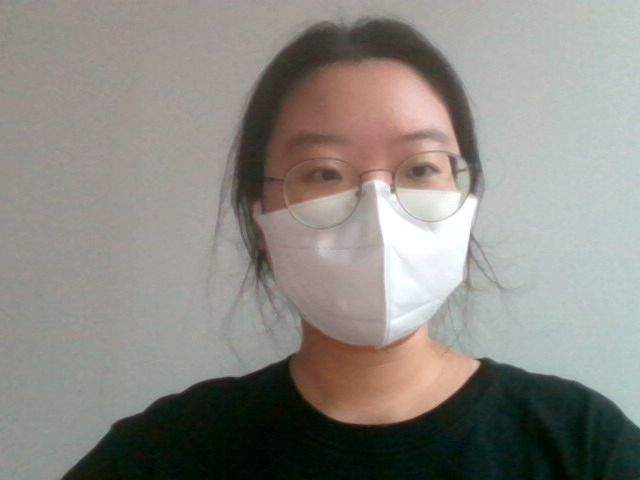

In [7]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [8]:
from scipy.spatial import distance

def calculate_EAR(eye):
#눈에 랜드마크 좌표를 찍어서 EAR값을 예측
	A = distance.euclidean(eye[1],eye[5]) 
	B = distance.euclidean(eye[2],eye[4])
	C = distance.euclidean(eye[0],eye[3])
	
	ear = (A+B) / (2.0 * C)
	return ear

In [9]:
hog_face_detector = dlib.get_frontal_face_detector()
dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

gray = cv2.imread('/content/result.jpg')
frame = cv2.imread('/content/result.jpg')

faces = hog_face_detector(gray)
for face in faces:
  face_landmarks = dlib_facelandmark(gray, face)
  leftEye = []
  rightEye = []

  for n in range(36,42):
    x = face_landmarks.part(n).x
    y = face_landmarks.part(n).y
    leftEye.append((x,y))
    next_point = n+1
    if n == 41:
         next_point = 36
    x2 = face_landmarks.part(next_point).x
    y2 = face_landmarks.part(next_point).y
    cv2.line(frame,(x,y),(x2,y2),(0,255,0),1)

  for n in range(42,48): # 왼쪽 눈 감지
    x = face_landmarks.part(n).x
    y = face_landmarks.part(n).y
    rightEye.append((x,y))
    next_point = n+1
    if n == 47:
      next_point = 42
    x2 = face_landmarks.part(next_point).x
    y2 = face_landmarks.part(next_point).y
    cv2.line(frame,(x,y),(x2,y2),(0,255,0),1)

  left_ear = calculate_EAR(leftEye)
  right_ear = calculate_EAR(rightEye)

  EAR = (left_ear+right_ear)/2
  EAR = round(EAR,2)
  print(EAR)

  if EAR < 0.3:
    print('Closed')
  else:
    print('Open')

0.4
Open


In [ ]:
import cv2

# haarcascade 불러오기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# 이미지 불러오기
img = cv2.imread('sample.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 얼굴 찾기
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # 눈 찾기
    roi_color = img[y:y + h, x:x + w]
    roi_gray = gray[y:y + h, x:x + w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

# 영상 출력
cv2.imshow('image', img)

key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
result = PIL.Image.open('/content/result.jpg')
area = (220, 80, 730, 600) # 이건 눈 크기에 맞게
crop_img = result.crop(area)

In [ ]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0   4419      0  0:00:01  0:00:01 --:--:--  4419


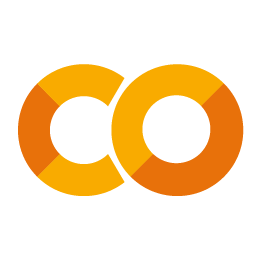

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)